['fs', 'workloads', 'total_time(ns)', 'meta(ns)', 'data(ns)', 'data_csum(ns)', 'comu(ns)']
        fs     workloads  total_time(ns)      meta(ns)      data(ns)  \
0     pmfs         write    3.755515e+11  3.432474e+11  3.230411e+10   
1     pmfs     randwrite    4.065859e+11  3.640763e+11  4.250969e+10   
2     pmfs  fileserver.f    2.012672e+06  1.546356e+06  4.663159e+05   
3     pmfs     varmail.f    1.222298e+04  6.016822e+03  6.206159e+03   
4     pmfs   webserver.f    4.851458e+03  1.983996e+03  2.867461e+03   
5     pmfs    webproxy.f    8.130729e+03  2.330632e+03  5.800097e+03   
6     nova         write    2.082912e+11  9.063266e+10  1.176586e+11   
7     nova     randwrite    2.413202e+11  1.019253e+11  1.393949e+11   
8     nova  fileserver.f    9.952081e+05  3.790028e+05  6.162053e+05   
9     nova     varmail.f    1.419680e+04  5.383425e+03  8.813375e+03   
10    nova   webserver.f    3.862390e+03  9.995923e+02  2.862798e+03   
11    nova    webproxy.f    6.363335e+03  2.2

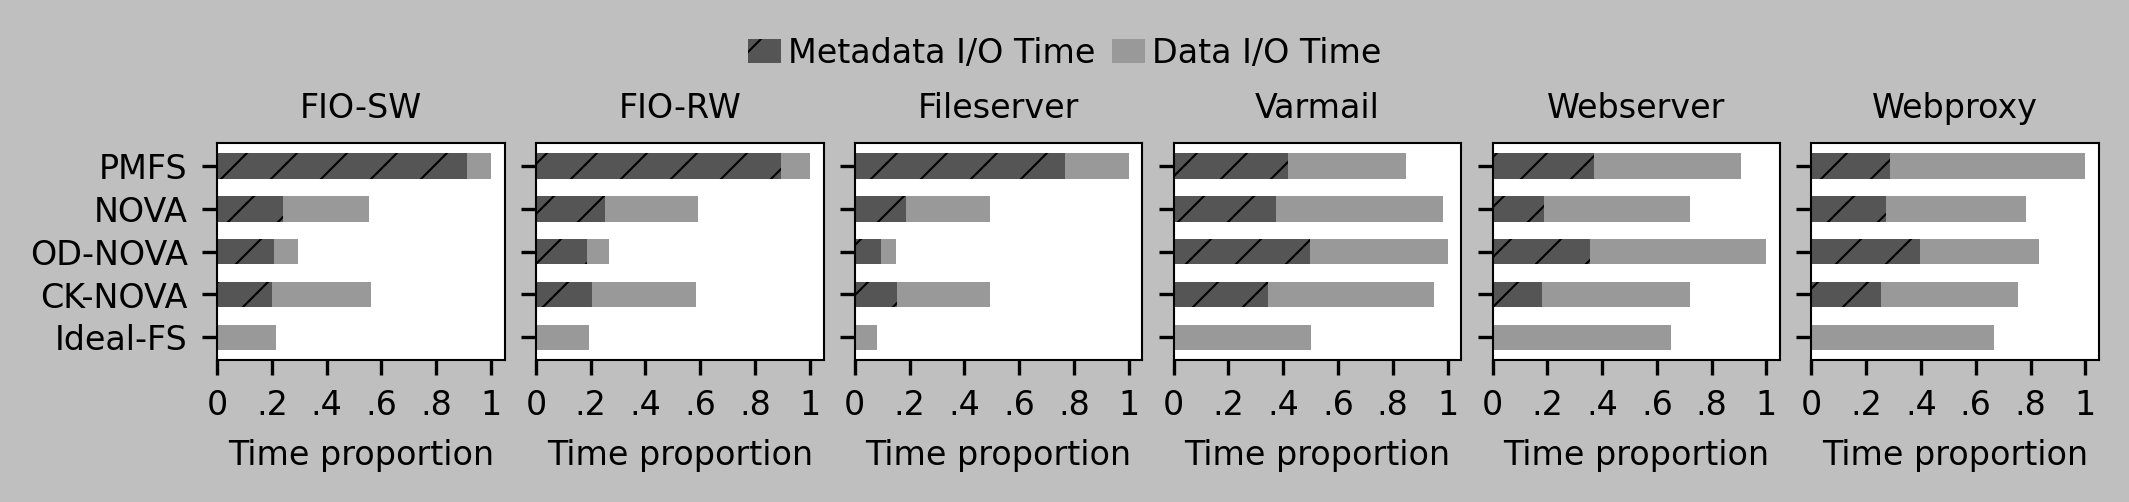

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54

plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42


# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(3.5)))
bar_width = 0.25
true_width = 0.15
inner_width = 0.1
num_job = 1

# grayscale colors
colors = ["#555555", "#999999", "#BBBBBB", "#DDDDDD", "#FFFFFF"]
patterns = ['//', '', '\\\\', "OOO", "///", "\\\\\\", "xxx"]
titles = ["(a) NOVA I/O Time and I/O Size Breakdown", "(b) PMFS I/O Time and I/O Size Breakdown"]
scales = [4, 1]
cmap="tab20"
# 文件路径和文件系统标记
files = [
    "./performance-comparison-table-pmfs",
    "./performance-comparison-table-nova",
    "./performance-comparison-table-nvodin",
    "./performance-comparison-table-cknova",
    "./performance-comparison-table-idel",
]
fss = ["pmfs", "nova", "nvodin", "cknova", "idel"]
combine_file = "./performance-comparison-table-combine"

all_data = []
for file, fs in zip(files, fss):
    df = pd.read_csv(file, sep=r"\s+", engine='python')
    df.insert(0, "fs", fs)
    all_data.append(df)

merged_df = pd.concat(all_data, ignore_index=True)

merged_df.to_csv(combine_file, index=False)

files = [combine_file]

workloads = ["write", "randwrite", "fileserver.f", "varmail.f", "webserver.f", "webproxy.f"]
# workloads = ["write", "randwrite"]
workloads_remap = ["FIO-SW", "FIO-RW", "Fileserver", "Varmail", "Webserver", "Webproxy"]
# workloads_remap = ["SW", "RW"]
# workloads = ["write", "webproxy.f"]
# workloads_remap = ["SW", "WPX"]

# workloads.reverse()
# workloads_remap.reverse()

# breakdown_times = ["data_read_time(ns)", "data_write_time(ns)", "update_entry_time(ns)", "update_inode_time(ns)", "journal_time(ns)", "update_page_tail_time(ns)"]
breakdown_times = ["meta(ns)", "data(ns)"]
bars = []
global_color_idx = 0
color_map = {}
for fid, file in enumerate(files):
    # subfig = plt.subplot(1, 2, fid + 1)
    with open(file, "r") as f:
        df = pd.read_csv(f, sep=",", engine='python')
    sort_dict = {
        "pmfs": 4,
        "nova": 3,
        "nvodin": 2,
        "cknova": 1,
        "idel": 0,
    }
    print(df.columns.tolist())
    print(df)
    sort_df = pd.DataFrame(df['fs'].map(sort_dict))
    df = df.iloc[sort_df.sort_values(by = ["fs"]).index]
    print(df)
    fss = df['fs'].drop_duplicates().reset_index().drop(columns=['index'])['fs']
    
    # fss = df['fs'].drop_duplicates().reset_index().drop(columns=['index'])['fs']
    # breakdown_times = ["data_write_time(ns)", "data_read_time(ns)", "update_package_time(ns)", "update_bm_time(ns)"]
    # df.columns[14:]
    # breakdown_times = breakdown_times.insert(0, "data_read_time(ns)")
    # breakdown_times = breakdown_times.insert(1, "data_write_time(ns)")
    x = list(range(1, len(workloads) + 1))
    
    # ax2 = subfig.twinx()
    pivots = []
    
    workload_map = {
        "write": [],
        "randwrite": [],
        "fileserver.f": [],
        "varmail.f": [],
        "webserver.f": [],
        "webproxy.f": []
    }

    for fs_idx, fs in enumerate(fss):
        for workload_id, workload in enumerate(workloads):
            total_time = df[(df['workloads'] == workload) & (df['fs'] == fs)]["total_time(ns)"].iloc[0]
            workload_map[workload].append(total_time)
    
    for workload_id, workload in enumerate(workloads):
        pivots = []
        for fs_idx, fs in enumerate(fss):
            subfig = plt.subplot(1, 6, workload_id + 1) 
            # global_color_idx = 0
            global_color_idx = fid * len(breakdown_times) 
            left = 0
            # for pivot in x:
            #     point = pivot - len(fss) * bar_width / 2 + bar_width / 2 + idx * bar_width
            #     points.append(point)
            # - tot / 2 + bar_width / 2 + idx * bar_width
            
            pivot = x[workload_id] - len(fss) * bar_width / 2 + bar_width / 2 + fs_idx * bar_width 
            pivots.append(pivot)
            # + bar_width / 2
            inner_left = 0
            inner_left_range = []
            start = False
            first = True
            for idx, time in enumerate(breakdown_times):
                width = df[(df['workloads'] == workload) & (df['fs'] == fs)][time].iloc[0] / max(workload_map[workload])
                if fs == "idel":
                    if first:
                        first = False
                        width = 0
                    else:
                        width = df[(df['workloads'] == workload) & (df['fs'] == fs)]["total_time(ns)"].iloc[0] / max(workload_map[workload])
                
                orig_global_color_idx = global_color_idx
                if fid == 1 and idx in [0, 1, 3, 4]:
                    global_color_idx = color_map[time]
                
                bar, = subfig.barh(y=pivot, width=width, color=colors[global_color_idx], left=left, hatch=patterns[idx],linewidth=0.5, label=time, height=true_width)
                left = left + width 
                
                global_color_idx = orig_global_color_idx

                if fid == 0:
                    color_map[time] = global_color_idx
                    global_color_idx += 1
                    if workload_id == 0:
                        bars.append(bar)
                else:
                    if idx not in [0, 1, 3, 4]:
                        global_color_idx += 1
                    if workload_id == 0:
                        if idx not in [0, 1, 3, 4]:
                            bars.append(bar)

        subfig.tick_params(bottom=False, top=False, left=False, right=False)

        # ax2.set_yticks(pivots)
        if workload_id == 0:
            _fss = fss.map({
                "idel": "Ideal-FS",
                "nova": "NOVA",
                "nvodin": "OD-NOVA",
                "cknova": "CK-NOVA",
                "pmfs": "PMFS",
            })
            yticklabels = list(_fss)
            subfig.set_yticks(pivots)
            subfig.set_yticklabels(yticklabels, fontsize=8)
        else:
            subfig.set_yticks(pivots)
            subfig.set_yticklabels([], fontsize=8)
        
        subfig.set_title(f"{workloads_remap[workload_id]}", fontsize=8)
        subfig.set_xlim([0, 1.05])
        subfig.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        subfig.set_xticklabels(["0", ".2", ".4", ".6", ".8", "1"], fontsize=8)
        subfig.set_xlabel("Time proportion", fontsize=8)
        
        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
        subfig.tick_params(bottom=True, top=False, left=True, right=False, which='major')
    # subfig.set_ylabel("Normalized Write Time per Op", fontsize=8)
    # if fid == 0:
    #     subfig.set_ylim([0, 1])
    #     subfig.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    #     subfig.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=8)
    #     # subfig.set_yticks([0, 0.125, 0.250, 0.375, 0.500, 0.625, 0.750, 0.875, 1.000])
    #     # subfig.set_yticklabels([0, 0.125, 0.250, 0.375, 0.500, 0.625, 0.750,0.875, 1.000], fontsize=8)
    #     # subfig.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
    #     # subfig.set_xticklabels([0, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=8)
    #     pass
    # else:
    #     subfig.set_yticks([0, 11, 22, 33, 44])
    #     subfig.set_yticklabels([0, 11, 22, 33, 44], fontsize=8)
    # ax2.set_ylim(subfig.get_ylim())
    # subfig.set_ylim([1, 3])
    # subfig.set_xticks(x, minor=False)
    # if fid == 0:
    #     subfig.set_xticklabels(workloads_remap, fontsize=8, minor=False)
    # else:
    #     subfig.set_xticklabels([], fontsize=8)

    
    # yticklabels = yticklabels * 6
    # pivots.sort()
    # pivots = [ round(pivot, 1) for pivot in pivots]
    # pivots = [ pivot - 0.001 if pivot in x else pivot for pivot in pivots]
    # print(pivots)
    # subfig.set_xticks(pivots, minor=True)
    # subfig.set_xticklabels(yticklabels, minor=True, fontsize=8, rotation=45, ha="right", rotation_mode="anchor", va="center")
    # subfig.get_xaxis().set_tick_params(which='major', pad=22)
    # print(pivots)
    # subfig.set_yticks(pivots, minor=True)
    # if workload_id == 0:
    #      subfig.set_yticklabels(yticklabels, minor=True, fontsize=8)
    # ax2.set_yticklabels(['Huge+P', 'Huge+P', 'Huge', 'Huge', 'Naive', 'Naive'], fontsize=7)
        
    # subfig.tick_params(bottom=False, top=False, left=False, right=False, which='minor')
    # subfig.title.set_text(titles[fid], fontsize=8)
print(len(bars))
# legends = ["T-D-Rd", "T-D-Wr", "T-M-E", "T-M-I", "T-M-Jnl", "T-M-T", "T-M-Idx", "T-M-DE", "IO-D", "IO-M" ]
# legends = ["D-Write Time", "D-Read Time", "Pkg Time", "CP Time" ]
legends = ["Metadata I/O Time", "Data I/O Time"]
fig.legend(labels=legends, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15), frameon=False, columnspacing=0.5, handletextpad=0.2, handlelength=1, borderpad=0.2, labelspacing=0.2, fontsize=8)
plt.tight_layout(pad=0.4)
plt.savefig("./FIG-PerfBreakDown.pdf", bbox_inches='tight', pad_inches=0)

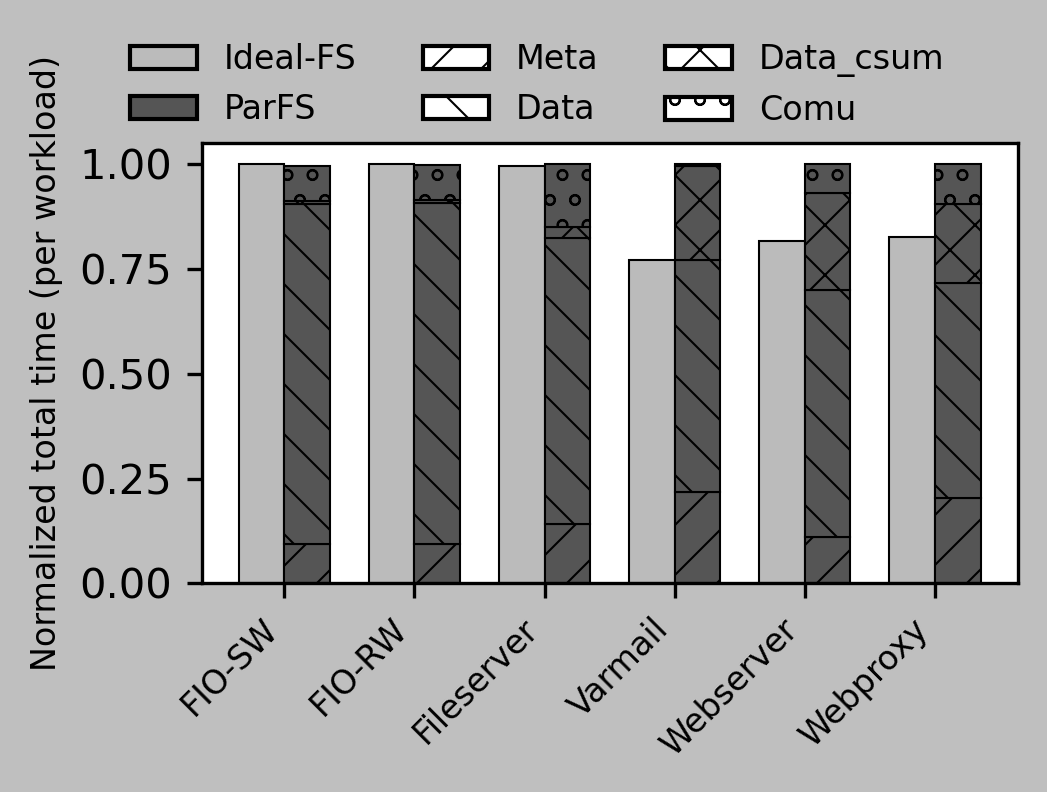

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches

# —————— 论文排版宽度设置 ——————
STANDARD_WIDTH = 17.8           # cm
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2

def cm_to_inch(cm):
    return cm / 2.54

# —————— 全局样式定义 ——————
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
style.use('grayscale')
plt.rcParams['axes.grid'] = False
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['hatch.color'] = 'black'

# —————— 读取并合并数据 ——————
files = {
    'idel':  './performance-comparison-table-idel',
    'parfs': './performance-comparison-table-parfs'
}
dfs = []
for fs, path in files.items():
    df0 = pd.read_csv(path, sep=r"\s+", engine='python')
    df0['fs'] = fs
    dfs.append(df0)
df = pd.concat(dfs, ignore_index=True)

# —————— 筛选目标 workloads ——————
workloads = ["write", "randwrite", "fileserver.f", "varmail.f", "webserver.f", "webproxy.f"]
labels    = ["FIO‑SW", "FIO‑RW", "Fileserver", "Varmail", "Webserver", "Webproxy"]
df = df[df['workloads'].isin(workloads)].copy()

# —————— 计算各部分占比 ——————
for col in ['meta(ns)', 'data(ns)', 'data_csum(ns)', 'comu(ns)']:
    df[f'{col}_frac'] = df[col] / df['total_time(ns)']

# —————— 按 workload 单独归一化总时间 ——————
df['max_per_wl'] = df.groupby('workloads')['total_time(ns)'].transform('max')
df['total_norm'] = df['total_time(ns)'] / df['max_per_wl']

# —————— 透视表 ——————
idx = 'workloads'
meta_frac = df.pivot(index=idx, columns='fs', values='meta(ns)_frac')
data_frac = df.pivot(index=idx, columns='fs', values='data(ns)_frac')
csum_frac = df.pivot(index=idx, columns='fs', values='data_csum(ns)_frac')
comu_frac = df.pivot(index=idx, columns='fs', values='comu(ns)_frac')
norm_ht   = df.pivot(index=idx, columns='fs', values='total_norm')

# —————— 绘图 ——————
fig, ax = plt.subplots(
    dpi=300,
    figsize=(cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(6))
)

x = np.arange(len(workloads))
width = 0.35

# — 颜色与纹理 —
col_idel   = "#BBBBBB"   # 浅灰
col_parfs  = "#555555"   # 深灰
h_meta     = "//"
h_data     = "\\\\"
h_csum     = "xx"
h_comu     = "oo"

# — 保证绘制顺序与 workloads 一致 —
idel_vals  = norm_ht.loc[workloads, 'idel'].values
parfs_norm = norm_ht.loc[workloads, 'parfs'].values

# — 绘制 Ideal‑FS —
ax.bar(
    x - width/2,
    idel_vals,
    width,
    facecolor=col_idel,
    edgecolor='black',
    linewidth=0.5
)

# — 绘制 ParFS 分解（按固定顺序） —
bottom = np.zeros_like(parfs_norm, dtype=float)
for frac_series, hatch, name in [
    (meta_frac['parfs'], h_meta,  'Meta'),
    (data_frac['parfs'], h_data,  'Data'),
    (csum_frac['parfs'], h_csum,  'Data_csum'),
    (comu_frac['parfs'], h_comu,  'Comu'),
]:
    heights = parfs_norm * frac_series.loc[workloads].values
    ax.bar(
        x + width/2,
        heights,
        width,
        bottom=bottom,
        facecolor=col_parfs,
        edgecolor='black',
        hatch=hatch,
        linewidth=0.5,
        label=name
    )
    bottom += heights

# — 坐标与标签 —
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax.set_ylabel("Normalized total time (per workload)", fontsize=8)
ax.set_ylim(0, 1.05)

# — 图例 —
p_idel  = mpatches.Patch(facecolor=col_idel,  edgecolor='black', label='Ideal‑FS')
p_parfs = mpatches.Patch(facecolor=col_parfs, edgecolor='black', label='ParFS')
p_meta  = mpatches.Patch(facecolor='white',  edgecolor='black', hatch=h_meta, label='Meta')
p_data  = mpatches.Patch(facecolor='white',  edgecolor='black', hatch=h_data, label='Data')
p_csum  = mpatches.Patch(facecolor='white',  edgecolor='black', hatch=h_csum, label='Data_csum')
p_comu  = mpatches.Patch(facecolor='white',  edgecolor='black', hatch=h_comu, label='Comu')

fig.legend(
    handles=[p_idel, p_parfs, p_meta, p_data, p_csum, p_comu],
    loc='upper center',
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 1.12),
    fontsize=8
)

plt.tight_layout()
plt.savefig("./FIG-PerfBreakDown-IDEL-PARFS.pdf", bbox_inches='tight', pad_inches=0)
plt.show()
